In [26]:
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoLarsIC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.pipeline import make_pipeline


### Functions used to summaries results:

In [13]:
def accuracy(model, y_test, x_test):
    pred = model.predict(x_test)
    mse = mean_squared_error(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)
    if model.__class__.__name__ == 'RegressionResultsWrapper':
        print('Multi linear regression\n----------')
    
    else:
        print('Lasso regression')
        
    
    print(f'Mean Squared Error: {round(mse,2)} \nMean Absolute Percentage Error: {round(mape*100,2)}%')

In [14]:
df = pd.read_csv('insurance_dataset.csv')
df

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,59,male,46.67,2,no,northeast,High blood pressure,NaN,Frequently,Student,Basic,11584.134900
999996,33,male,36.83,2,no,northeast,NaN,High blood pressure,Frequently,Unemployed,Basic,9834.871456
999997,39,male,39.84,0,yes,northeast,Heart disease,High blood pressure,Rarely,Blue collar,Standard,22076.632856
999998,37,female,45.06,4,yes,northeast,High blood pressure,Diabetes,Occasionally,Unemployed,Premium,20297.618728


## Medical insurance charges
- **Age**: The age of the insured individual.
- **Gender**: The gender of the insured individual.
- **BMI** (Body Mass Index): A measure of body fat based on height and weight.
- **Children**: The number of children covered by the insurance plan.
- **Smoking Status**: Indicates whether the individual is a smoker.
- **Region**: The geographical region of the insured individual.
- **Medical History**: Information about the individual's old medical problems.
- **Family Medical History**: Information about the family's medical record.
- **Exercise Frequency**: The frequency of the individual's exercise routine.
- **Occupation**: The occupation of the insured individual.
- **Coverage Level**: The type of insurance plan.
- **Charges**: The health insurance charges for the individual

Data is from Kaggle: https://www.kaggle.com/datasets/sridharstreaks/insurance-data-for-machine-learning/data



## Possible questions:

1. Insurance industry today is full of data on their customers. What we aim to do is to figure out if an insurance company can leverage this data to automate decissions. We will look at whether there is machine learning models that can accuratly set the "coverage_level" of a customer, and if a model can, with good accuracy, set a "charge" to a customer. 

- TSNE to convert data to 2D plane and use clustering to predict future data points "coverage_level".

- Some regression to predict charge.

- Discuss whether the accuracy is good enough for this model to be used by a company. Are there ethical problems with this? Like is it a problem that the model can set higher charges at times due to predictions being somehwat unaccurate. Should we use some regression type, like ridge, to lower the predictions such that this ethical issue is minimized. This could be justified by the savings the company gets from automizing the process.

- Is it ethical to use familiy records to set price

- Se lovverket hva som er lov å diskriminere mot

In [4]:
df # Should we add a constant term?

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,NaN,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,NaN,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,59,male,46.67,2,no,northeast,High blood pressure,NaN,Frequently,Student,Basic,11584.134900
999996,33,male,36.83,2,no,northeast,NaN,High blood pressure,Frequently,Unemployed,Basic,9834.871456
999997,39,male,39.84,0,yes,northeast,Heart disease,High blood pressure,Rarely,Blue collar,Standard,22076.632856
999998,37,female,45.06,4,yes,northeast,High blood pressure,Diabetes,Occasionally,Unemployed,Premium,20297.618728


## Regressions

In [15]:
# Divide into dependent and independent vairables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.30)
X_train['charges'] = y_train
training = X_train.copy()

In [16]:
# Good way to code regression with categorical variables
formula = 'charges ~ age + C(gender) + bmi + children + C(smoker) + C(region) + C(medical_history) + C(family_medical_history) + C(exercise_frequency) + C(occupation) + C(coverage_level)'
model = smf.ols(formula = formula, data = training).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.287e+06
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:46:35   Log-Likelihood:            -2.7821e+06
No. Observations:              392687   AIC:                         5.564e+06
Df Residuals:                  392666   BIC:                         5.565e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          1.05e+04      3.008   3490.335      0.000    1.05e+04    1.05e+04
C(gender)[T.male]                                  999.2702      0.922   1083.916      0.000     997.463    1001.077
C(smoker)[T.yes]                                  4998.1125      0.922   5421.368      0.000    4996.306    4999.919
C(region)[T.northwest]                            -700.7990      1.303   -537.914      0.000    -703.352    -698.246
C(region)[T.southeast]                            -500.0896      1.302   -384.075      0.000    -502.642    -497.538
C(region)[T.southwest]                            -799.0734      1.303   -613.322      0.000    -801.627    -796.520
C(medical_history)[T.Heart disease]               3000.6234      1.129   2658.634      0.000    2998.411    3002.836
C(medical_history)[T.High blood pressure]        -1001.0399      1.130   -885.939      0.000   -1003.255    -998.825
C(family_medical_history)[T.Heart disease]        3001.5034      1.129   2658.016      0.000    2999.290    3003.717
C(family_medical_history)[T.High blood pressure]  -999.8916      1.130   -885.024      0.000   -1002.106    -997.677
C(exercise_frequency)[T.Never]                   -1999.1962      1.305  -1532.376      0.000   -2001.753   -1996.639
C(exercise_frequency)[T.Occasionally]             -997.1468      1.304   -764.660      0.000    -999.703    -994.591
C(exercise_frequency)[T.Rarely]                  -1498.6333      1.303  -1149.706      0.000   -1501.188   -1496.078
C(occupation)[T.Student]                          -997.5391      1.303   -765.632      0.000   -1000.093    -994.985
C(occupation)[T.Unemployed]                      -1498.3647      1.303  -1150.034      0.000   -1500.918   -1495.811
C(occupation)[T.White collar]                      501.9356      1.305    384.581      0.000     499.378     504.494
C(coverage_level)[T.Premium]                      4999.8131      1.130   4424.612      0.000    4997.598    5002.028
C(coverage_level)[T.Standard]                     2000.5725      1.129   1772.473      0.000    1998.360    2002.785
age                                                 19.9835      0.033    601.048      0.000      19.918      20.049
bmi                                                 49.9837      0.050   1001.026      0.000      49.886      50.082
children                                           200.0756      0.270    741.370      0.000     199.547     200.605
==============================================================================
Omnibus:                   355931.752   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23647.193
Skew:                           0.000 

In [36]:
accuracy(model, y_test, X_test)

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'gender' is not defined
    charges ~ age + C(gender) + bmi + children + C(smoker) + C(region) + C(medical_history) + C(family_medical_history) + C(exercise_frequency) + C(occupation) + C(coverage_level)
                    ^^^^^^^^^

## Regularization with Lasso

In [37]:
lasso_df = pd.get_dummies(df) # Important for preparing the data for Lasso regression

X_lasso = lasso_df.drop('charges', axis = 1)
y_lasso = lasso_df.iloc[:, 3]

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_lasso,y_lasso, test_size= 0.30)


#### Using AIC to determine the alpha hyperparameter for Lasso regression

In [20]:
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion='aic')).fit(X_train_l, y_train_l)

c:\Users\ikorn\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=4.596e+02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\ikorn\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=2.295e+02, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
c:\Users\ikorn\anaconda3\Lib\site-packages\sklearn\linear_model\_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 18 iterations, alpha=2.295e+02, previous alpha=2.287e+02

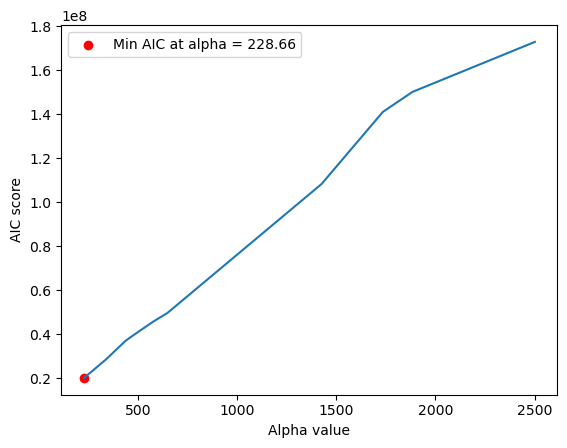

In [21]:
results = pd.DataFrame({
    'alphas': lasso_lars_ic[-1].alphas_,
    'aic criterion': lasso_lars_ic[-1].criterion_,
})

plt.plot(results['alphas'], results['aic criterion'])
plt.xlabel('Alpha value')
plt.ylabel('AIC score')
min_aic = results.min().tolist()
plt.scatter(min_aic[0], min_aic[1], c = 'red', label = f'Min AIC at alpha = {round(min_aic[0],2)}')

plt.legend()
plt.show()

- The LassoLarsIC API stops at that point because it estimates that it is converging. Continuing would introduce numerical errors higher than the remaining correlation according to sklearn documentation. 

In [22]:
clf = Lasso(alpha=0.21, fit_intercept=True, max_iter=10000)
clf.fit(X_train_l, y_train_l)

Lasso(alpha=0.21, max_iter=10000)

In [14]:
accuracy(clf, y_test_l, X_test_l)

Lasso regression
Mean Squared Error: 83613.13 
Mean Absolute Percentage Error: 1.62%


#### Interpretation

Seems Lasso yields little improvement from the basic OLS model. This is of no suprise as on the summary for the OLS model it seemed to strongly indicate that all variables are important. Since Lasso is a linear regression with a penalty term that helps to prevent overfitting and facilitate automatic feature selection, it is not suprising that it did not yield uch improvements as all features in the dataset are important. Thus, for simplicity, we continue with the OLS.

In [25]:
df = pd.read_csv('insurance_dataset.csv')

# Define independent and dependent variables
X = df.drop('charges', axis=1)
y = df['charges']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)
X

,age,bmi,children,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest,medical_history_Heart disease,medical_history_High blood pressure,family_medical_history_Heart disease,family_medical_history_High blood pressure,exercise_frequency_Never,exercise_frequency_Occasionally,exercise_frequency_Rarely,occupation_Student,occupation_Unemployed,occupation_White collar,coverage_level_Premium,coverage_level_Standard
0,46,21.45,5,True,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False
1,25,25.38,2,False,True,True,False,False,False,False,False,True,False,True,False,False,False,True,True,False
2,38,44.88,2,True,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True,False
3,25,19.89,0,True,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True
4,49,38.21,3,True,True,True,False,False,False,False,False,True,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,59,46.67,2,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
999996,33,36.83,2,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
999997,39,39.84,0,True,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True
999998,37,45.06,4,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False


In [27]:
# define the model pipeline with standard scaling and Lasso regression
lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=0.21, max_iter=10000))

# set up K-Fold with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=2)

In [28]:
mse_scorer = make_scorer(mean_squared_error)
#cross-validation and get MSE scores
mse_scores = cross_val_score(lasso_pipeline, X, y, cv=kf, scoring=mse_scorer)

print("MSE for each fold:", mse_scores)
print("Average MSE:", mse_scores.mean())

MSE for each fold: [1087058.43337305 1085574.20422145 1085064.02687501 1077676.93576959
 1089130.5826431  1078297.08713946 1084337.30078445 1083327.55370126
 1085337.39077996 1081698.59216504]
Average MSE: 1083750.2107452361


In [33]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV, Ridge
import numpy as np


df = pd.read_csv('insurance_dataset.csv')

alphas = np.logspace(-4, 4, 100)
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')).fit(X_train_l, y_train_l)

best_alpha_ridge = ridge_cv[-1].alpha_
ridge_model = Ridge(alpha=best_alpha_ridge).fit(X_train_l, y_train_l)

y_pred_ridge = ridge_model.predict(X_test_l)
ridge_mse = mean_squared_error(y_test_l, y_pred_ridge)

print(f"Best alpha for Ridge Regression: {best_alpha_ridge}")
print(f"Mean Squared Error on test data: {ridge_mse}")




Best alpha for Ridge Regression: 0.055908101825122285
Mean Squared Error on test data: 83314.1287528692


In [34]:
#Ridge with same alpha as for Lasso regression
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')).fit(X_train_l, y_train_l)
ridge_model = Ridge(alpha=0.21).fit(X_train_l, y_train_l)
y_pred_ridge = ridge_model.predict(X_test_l)
ridge_mse = mean_squared_error(y_test_l, y_pred_ridge)
print(f"Mean Squared Error on test data: {ridge_mse}")


Mean Squared Error on test data: 83314.12750601213
